In [75]:
import networkx as nx
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import pickle
import os

import matplotlib as plt
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint

In [2]:
%reload_ext dotenv
%dotenv -o

CITY_NAME = os.environ["CITY_NAME"]
CITY_SLUG = os.environ["CITY_SLUG"]
print(f"City name: {CITY_NAME}")
print(f"City slug: {CITY_SLUG}")

City name: Cambridge, MA, USA
City slug: cambridge_ma


## Read data

This shouldn't take longer than ~40 sec.

### Load graph, separate to nodes and edges

In [52]:
# ~15 sec
with open(f"./data/{CITY_SLUG}_networkx_graph.pkl", "rb") as fin:
    G = pickle.load(fin)

og_edges = list(G.edges)
for u, v, i in og_edges:
    if i > 0:
        G.remove_edge(u, v, i)
    
print(f"Graph has:")
print(f"  {G.number_of_nodes():,} nodes")
print(f"  {G.number_of_edges():,} edges")

Graph has:
  1,830 nodes
  4,092 edges


In [53]:
import warnings
warnings.filterwarnings("ignore")

def plot_base_network():
    %matplotlib agg
    fig, ax = plt.subplots()
    ox.plot_graph(
        G, ax=ax,
        figsize=(8, 8),
        bgcolor="#fff", edge_color="#000", node_color="#000",
        node_size=5, edge_linewidth=0.5
    )
    %matplotlib inline
    return fig, ax

In [54]:
nodes, edges = ox.graph_to_gdfs(G)

### Load boba shop locations

In [55]:
# Hack from https://stackoverflow.com/questions/71907567/valueerror-geodataframe-does-not-support-multiple-columns-using-the-geometry-co
boba_gdf = gpd.read_file(f"./data/{CITY_SLUG}_boba_shops.csv",
                         GEOM_POSSIBLE_NAMES="geometry", 
                         KEEP_GEOM_COLUMNS="NO")
boba_gdf = boba_gdf[["id", "location", "geometry"]]
boba_gdf.head()

,id,location,geometry
0,cNNTPEqz5uMY5cjCW7M8oA,"{'address1': '425 Massachusetts Ave', 'address...",POINT (-71.10147 42.36408)
1,sKkCCr951o-wtPccNfPINw,"{'address1': '100 Cambridgeside Pl', 'address2...",POINT (-71.07599 42.36878)
2,RzcDKKBkxy1JPCEFoGrV8A,"{'address1': '100 Cambridgeside Pl', 'address2...",POINT (-71.07599 42.36878)
3,996jyfv8Q6yyxJDFb8x4qA,"{'address1': '605 Massachusetts Ave', 'address...",POINT (-71.10298 42.36517)
4,RFMiG4t35kNr4Iz3ndu3nw,"{'address1': '955 Massachusetts Ave', 'address...",POINT (-71.11007 42.36911)


### Generate intersections of nearest boba shops

In [56]:
nodes.head(1)

,y,x,highway,street_count,geometry
osmid,,,,,
61182955,42.385184,-71.116133,traffic_signals,4,POINT (-71.11613 42.38518)


In [57]:
end_nodes = set()

for _, row in boba_gdf.iterrows():
    x, y = row["geometry"].x, row["geometry"].y
    node = ox.nearest_nodes(G, x, y)
    end_nodes.add(node)
    for edge in G.in_edges(node):
        end_nodes.add(edge[0])

end_nodes = list(end_nodes)

In [58]:
print(len(end_nodes), len(boba_gdf))

40 13


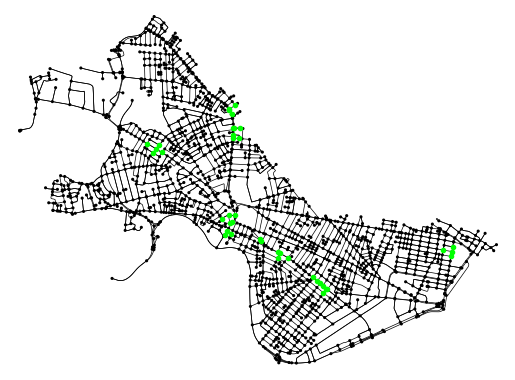

In [59]:
# Select rows of dataframe that match with endpoints
end_gdf = nodes.loc[end_nodes]

fig, ax = plot_base_network()
ax.plot(end_gdf["geometry"].x, end_gdf["geometry"].y, "o", markersize=3, c="#0f0")
fig

### Generate adjacency list

In [90]:
from collections import defaultdict
import re

adj = defaultdict(dict)
for u, v in tqdm(G.edges()):
    data = G.get_edge_data(u, v)[0]
    
    if "maxspeed" not in data or isinstance(data["maxspeed"], float):
        maxspeed = 25        
    else:
        if isinstance(data["maxspeed"], str):
            # Terrible hack needed because sometimes it's str and sometimes
            #   it's a list of strs
            data["maxspeed"] = [data["maxspeed"]]

        maxspeed = np.mean(list(map(
            lambda s: int(re.fullmatch(r"(\d+)( mph)?", s).group(1)),
            data["maxspeed"]
        )))

    # Calculate travel time in minutes
    t = round(data["length"] / (maxspeed * 1609.34) * 60, 3)
    G[u][v][0]["time"] = t


    # Add this to the adjacency list
    adj[u][v] = t

for node in adj:
    adj[node] = list(adj[node].items())

100%|██████████| 4092/4092 [00:00<00:00, 9627.08it/s] 


In [91]:
pprint(list(adj.items())[:10])

[(61182955, [(61323200, 0.177)]),
 (61283119, [(61283126, 0.157), (61321743, 0.203), (61283322, 0.066)]),
 (61283126, [(61321144, 0.153), (61331850, 0.2), (61283315, 0.064)]),
 (61283218, [(61324632, 0.674), (61283269, 1.242), (61317302, 0.165)]),
 (61283269,
  [(61321312, 0.399),
   (6100432137, 0.744),
   (61283218, 1.242),
   (61323022, 0.177)]),
 (61283273, [(61283287, 0.299), (61283333, 0.158), (61283340, 0.136)]),
 (61283287, [(61321748, 0.181)]),
 (61283293, [(568218971, 0.014), (61283311, 0.094)]),
 (61283300, [(61283287, 0.113)]),
 (61283305, [(61317713, 0.102), (61283345, 0.109)])]


In [92]:
# Color nodes based on their travel times as a santify check
edge_times = list(nx.get_edge_attributes(G, "time").values())

def float_to_hex_color(float_list, colormap="viridis"):
    norm = plt.Normalize(min(float_list), max(float_list))
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=colormap)

    hex_colors = [mcolors.to_hex(mapper.to_rgba(value)) for value in float_list]
    return hex_colors

edge_colors = float_to_hex_color(edge_times)

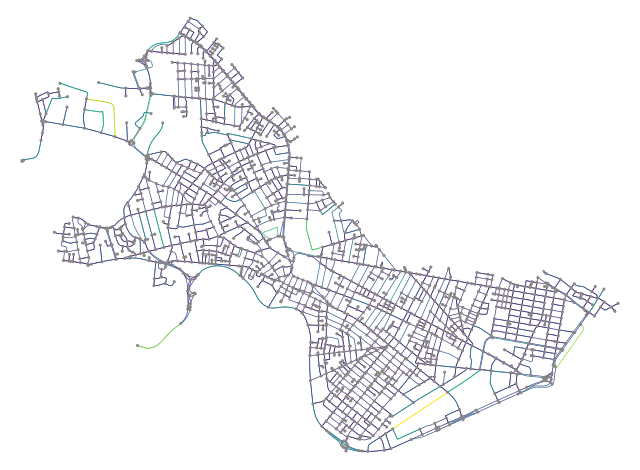

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [93]:
ox.plot_graph(
    G,
    figsize=(8, 8),
    bgcolor="#fff", edge_color=edge_colors, node_color="#888",
    node_size=5, edge_linewidth=0.5
)

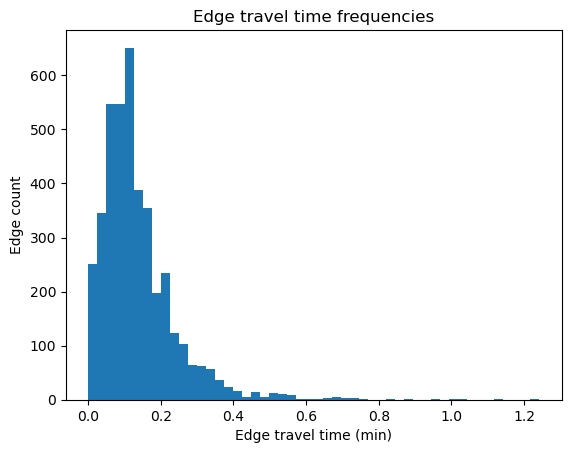

In [99]:
plt.xlabel("Edge travel time (min)")
plt.ylabel("Edge count")
plt.title("Edge travel time frequencies")
plt.hist(edge_times, bins=50);

## Generating random walks

In [100]:
import random

In [101]:
startY, startX = ox.geocoder.geocode("Harvard Yard, MA, USA")
start = ox.nearest_nodes(G, startX, startY)

print(f"Starting at osmid={start}:")
print(nodes.loc[start])

print(f"\n{nodes.loc[start].y}, {nodes.loc[start].x}")

Starting at osmid=61324477:
y                                    42.372891
x                                   -71.117123
highway                                    NaN
street_count                                 3
geometry        POINT (-71.1171226 42.3728906)
Name: 61324477, dtype: object

42.3728906, -71.1171226


In [ ]:
# Keep visiting nodes till we hit something in end_nodes
cur = start
t = 0
path = []

while cur not in end_nodes:
    path.append((cur, t))
    